# **Import Library**

In [24]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
import shutil

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.stats.mstats import winsorize
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm



# **Functions**

In [25]:
def convert_region(df, variableName: str):
    vietnam_regions = {
        "Dong Bang Song Hong": [
            "Ha Noi", "Hai Duong", "Nam Dinh", "Hai Phong"
        ],
        "Trung du va Mien Nui Phia Bac": [
            "Thai Nguyen", "Hoa Binh", "Viet Tri", "Yen Bai",
            "Hong Gai", "Cam Pha", "Uong Bi"
        ],
        "Bac Trung Bo va Duyen Hai Mien Trung": [
            "Thanh Hoa", "Vinh", "Hue", "Tam Ky", "Nha Trang",
            "Qui Nhon", "Tuy Hoa", "Phan Rang", "Cam Ranh"
        ],
        "Tay Nguyen": [
            "Buon Me Thuot", "Da Lat", "Play Cu"
        ],
        "Dong Nam Bo": [
            "Ho Chi Minh City", "Bien Hoa", "Vung Tau", "Phan Thiet"
        ],
        "Dong Bang Song Cuu Long": [
            "Can Tho", "Ben Tre", "Vinh Long", "Tan An",
            "My Tho", "Long Xuyen", "Chau Doc", "Tra Vinh",
            "Bac Lieu", "Ca Mau", "Soc Trang", "Rach Gia"
        ]
    }

    province_to_region = {city: region for region, cities in vietnam_regions.items() for city in cities}
    df[variableName] = df[variableName].map(province_to_region)
    return df

In [26]:
def split_date(df, variableName: str):
  df[variableName] = pd.to_datetime(df[variableName])
  df['day'] = df[variableName].dt.day
  df['month'] = df[variableName].dt.month
  df['year'] = df[variableName].dt.year
  df.drop(columns=[variableName], inplace=True)
  return df

In [27]:
def boxplots(df):
  numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns
  plt.figure(figsize=(16, 5))

  for i, column in enumerate(numerical_columns, 1):
      plt.subplot(1, len(numerical_columns), i)
      sns.boxplot(data=df, y=column)
      plt.title(f"Boxplot of {column}")
      plt.ylabel(column)

  plt.tight_layout()
  plt.show()

In [28]:
def findSignificant(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return lower_bound, upper_bound

def Clipping(df):
  lower_bound, upper_bound = findSignificant(df)
  df = df.clip(lower=lower_bound, upper=upper_bound)
  return df

In [29]:
def oLs(df, x_var: str, y_var: str):
  model = OLS(df[x_var], sm.add_constant(df[y_var])).fit()
  return model

def ols_metrics(df, x_var: str, y_var: str):
  model = oLs(df, x_var, y_var)

  adj_r_squared = model.rsquared_adj
  f_statistic = model.fvalue
  Prob_F = model.f_pvalue
  return (adj_r_squared, f_statistic, Prob_F)

In [30]:
def anova(df, dl_var: str, dt_var: str):
  model = ols(f'{dl_var} ~ {dt_var}', data= df).fit()
  return model

def anova_metrics(df, dl_var: str, dt_var: str):
  model = anova(df, dl_var, dt_var)
  anova_table = anova_lm(model)

  F_value = anova_table.loc[dt_var, 'F']
  Prob_F = anova_table.loc[dt_var, 'PR(>F)']
  ss_between = anova_table.loc[dt_var, 'sum_sq']
  ss_total = anova_table['sum_sq'].sum()

  eta_squared = ss_between / ss_total
  return (eta_squared, F_value, Prob_F)

# **Setup Data**

In [31]:
import kagglehub

path = kagglehub.dataset_download("vanviethieuanh/vietnam-weather-data")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\HNS\.cache\kagglehub\datasets\vanviethieuanh\vietnam-weather-data\versions\1


In [32]:
dest_path = "./vietnam-weather-data"
if not os.path.exists(dest_path):
    shutil.copytree(path, dest_path)

csv_path = os.path.join(dest_path, 'weather.csv')
reworked_df = pd.read_csv(csv_path)

reworked_df = reworked_df[reworked_df["province"] != "Hanoi"]
reworked_df = reworked_df.rename(columns={
    'max': 'max_temp',
    'min': 'min_temp',
    'wind': 'wind_speed',
    'wind_d': 'wind_direct'
})

print(reworked_df.head())

   province  max_temp  min_temp  wind_speed wind_direct  rain  humidi  cloud  \
0  Bac Lieu        27        22          17         NNE   6.9      90     71   
1  Bac Lieu        31        25          20         ENE   0.0      64     24   
2  Bac Lieu        29        24          14           E   0.0      75     45   
3  Bac Lieu        30        24          30           E   0.0      79     52   
4  Bac Lieu        31        25          20         ENE   0.0      70     24   

   pressure        date  
0      1010  2009-01-01  
1      1010  2010-01-01  
2      1008  2011-01-01  
3      1012  2012-01-01  
4      1010  2013-01-01  


In [33]:
#Adding new clounms and split date column
df_copy = reworked_df.copy()
df_copy['range_temp'] = df_copy['max_temp'] - df_copy['min_temp']
df_copy['region'] = df_copy['province']
df_copy = convert_region(df_copy, 'region')
df_copy = split_date(df_copy, 'date')

In [34]:
df_copy['date'] = pd.to_datetime(df_copy[['year', 'month', 'day']])

# Sort the data so lags make sense (grouped by province, by time)
df_copy = df_copy.sort_values(['province', 'date'])

# Create lag features per province
df_copy['rain_1d_ago'] = df_copy.groupby('province')['rain'].shift(1)
df_copy['rain_3d_avg'] = df_copy.groupby('province')['rain'].shift(1).rolling(3).mean().reset_index(0, drop=True)
df_copy['rain_7d_sum'] = df_copy.groupby('province')['rain'].shift(1).rolling(7).sum().reset_index(0, drop=True)
df_copy[['rain_1d_ago', 'rain_3d_avg', 'rain_7d_sum']] = df_copy[
    ['rain_1d_ago', 'rain_3d_avg', 'rain_7d_sum']
].fillna(0)

In [35]:
# Rain trend: 3-day moving average (shifted to avoid leakage)
df_copy['rain_trend_3d'] = df_copy['rain'].rolling(window=3).mean().shift(1).fillna(0)

# Rain intensity: today's rain compared to past 7-day average (shifted)
df_copy['rain_intensity'] = (df_copy['rain'] / (df_copy['rain'].rolling(7).mean().shift(1) + 1e-5)).fillna(0)

In [36]:
df_copy['is_rainy_season'] = df_copy['month'].apply(lambda x: 1 if 5 <= x <= 11 else 0)
df_copy['is_dry_season'] = df_copy['month'].apply(lambda x: 1 if x in [12, 1, 2, 3, 4] else 0)

In [37]:
# Bảng chuyển hướng gió sang góc
direction_to_angle = {
    'N': 0, 'NE': 45, 'E': 90, 'SE': 135,
    'S': 180, 'SW': 225, 'W': 270, 'NW': 315
}

# Chuyển thành góc (radian)
df_copy['wind_angle'] = df_copy['wind_direct'].map(direction_to_angle).fillna(0)
theta = np.radians(df_copy['wind_angle'])
 
# Tạo hai feature mới
df_copy['wind_x'] = df_copy['wind_speed'] * np.cos(theta)
df_copy['wind_y'] = df_copy['wind_speed'] * np.sin(theta)

In [38]:
# Trung bình mưa theo province
df_copy['avg_rain_province'] = df_copy.groupby('province')['rain'].transform('mean')

# Trung bình mưa theo region
df_copy['avg_rain_region'] = df_copy.groupby('region')['rain'].transform('mean')

In [39]:
# Feature 1: Tính nhiệt độ ẩm từ range_temp và humidi
df_copy['temp_humidity'] = df_copy['range_temp'] * df_copy['humidi']
# Feature 2: Tính lại tốc độ gió từ wind_x và wind_y
df_copy['wind_speed'] = np.sqrt(df_copy['wind_x']**2 + df_copy['wind_y']**2)

In [40]:
# Mây và độ ẩm tương tác
df_copy['cloud_humid'] = df_copy['cloud'] * df_copy['humidi']

# Mây và dao động nhiệt độ tương tác
df_copy['cloud_temp_range'] = df_copy['cloud'] * df_copy['range_temp']


In [41]:
df_copy['avg_rain_region'] = df_copy.groupby('region')['rain'].transform('mean')
df_copy['avg_rain_region'] = df_copy['avg_rain_region'].fillna(0)

df_copy['rain_2d_ago'] = df_copy.groupby('province')['rain'].shift(2)
df_copy['rain_2d_ago'] = df_copy['rain_2d_ago'].fillna(0)


In [42]:
coord_df = pd.read_csv("vietnam-weather-data/Final_Province_Coordinates.csv")

# Gộp dữ liệu theo cột 'province'
df_copy = pd.merge(df_copy, coord_df, on='province', how='left')
df_copy =df_copy.drop(columns=['region_x'])
df_copy = df_copy.rename(columns={'region_y': 'region'})
# Kiểm tra xem merge có bị thiếu tỉnh nào không
print(df_copy.isnull().sum())

# (Tùy chọn) Lưu ra file mới nếu cần
df_copy.to_csv("final_weather.csv", index=False)


province             0
max_temp             0
min_temp             0
wind_speed           0
wind_direct          0
rain                 0
humidi               0
cloud                0
pressure             0
range_temp           0
day                  0
month                0
year                 0
date                 0
rain_1d_ago          0
rain_3d_avg          0
rain_7d_sum          0
rain_trend_3d        0
rain_intensity       0
is_rainy_season      0
is_dry_season        0
wind_angle           0
wind_x               0
wind_y               0
avg_rain_province    0
avg_rain_region      0
temp_humidity        0
cloud_humid          0
cloud_temp_range     0
rain_2d_ago          0
Latitude             0
Longitude            0
region               0
dtype: int64


# **df_copy Overview**

In [43]:
#5 fist row of this dataset

from tabulate import tabulate
print(tabulate(df_copy.head(10), headers='keys', tablefmt='psql'))

print(df_copy.shape)

+----+------------+------------+------------+--------------+---------------+--------+----------+---------+------------+--------------+-------+---------+--------+---------------------+---------------+---------------+---------------+-----------------+------------------+-------------------+-----------------+--------------+--------------+----------+---------------------+-------------------+-----------------+---------------+--------------------+---------------+------------+-------------+-------------------------+
|    | province   |   max_temp |   min_temp |   wind_speed | wind_direct   |   rain |   humidi |   cloud |   pressure |   range_temp |   day |   month |   year | date                |   rain_1d_ago |   rain_3d_avg |   rain_7d_sum |   rain_trend_3d |   rain_intensity |   is_rainy_season |   is_dry_season |   wind_angle |       wind_x |   wind_y |   avg_rain_province |   avg_rain_region |   temp_humidity |   cloud_humid |   cloud_temp_range |   rain_2d_ago |   Latitude |   Longitude 

#**Data Preprocessing**

In [44]:
#Check for missing data
print('Missing data in  DataFrame:\n',df_copy.isnull().sum())
#check for duplicaiton
print('Duplicate in DataFrame: ',df_copy.duplicated().sum())

Missing data in  DataFrame:
 province             0
max_temp             0
min_temp             0
wind_speed           0
wind_direct          0
rain                 0
humidi               0
cloud                0
pressure             0
range_temp           0
day                  0
month                0
year                 0
date                 0
rain_1d_ago          0
rain_3d_avg          0
rain_7d_sum          0
rain_trend_3d        0
rain_intensity       0
is_rainy_season      0
is_dry_season        0
wind_angle           0
wind_x               0
wind_y               0
avg_rain_province    0
avg_rain_region      0
temp_humidity        0
cloud_humid          0
cloud_temp_range     0
rain_2d_ago          0
Latitude             0
Longitude            0
region               0
dtype: int64
Duplicate in DataFrame:  0


# **Handling Outlier**

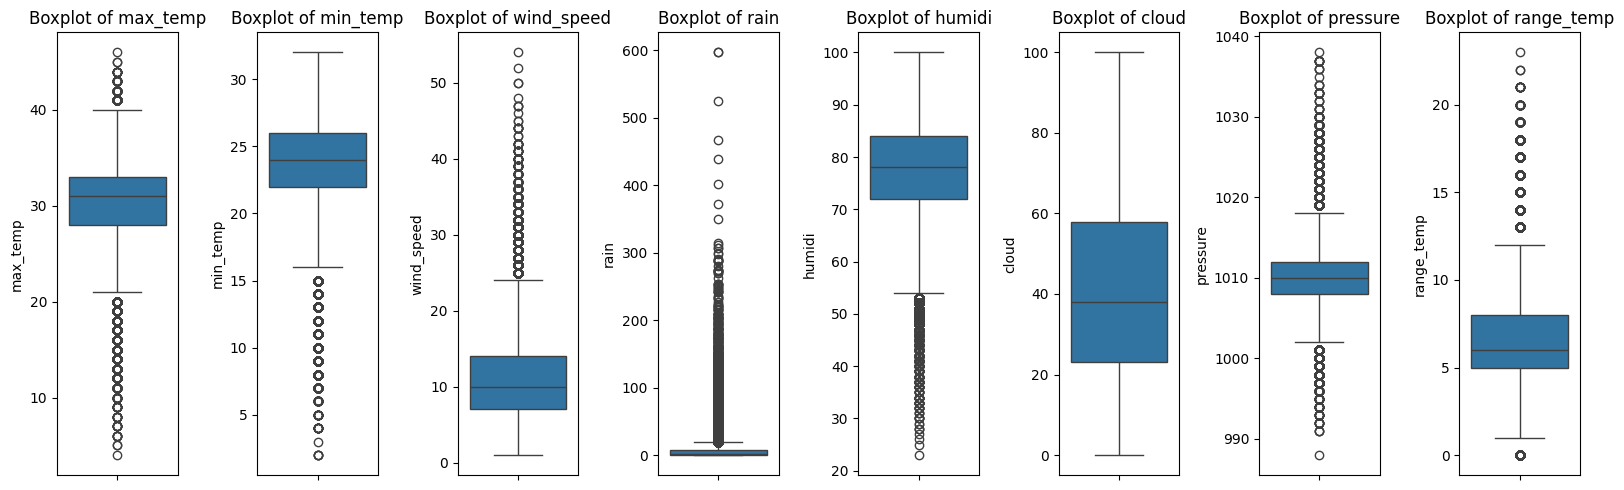

In [45]:
#Boxplot before handle outlier
boxplots(df_copy.drop(columns=['region', 'day', 'month', 'year','is_rainy_season','is_dry_season','avg_rain_region','avg_rain_province','rain_1d_ago','rain_3d_avg','rain_7d_sum', 'rain_intensity','temp_humidity','cloud_humid','rain_trend_3d','wind_angle','wind_x','wind_y','cloud_temp_range','rain_2d_ago','Latitude','Longitude'], axis=1))

In [46]:
# Handling outlier by clipping
df_clean = df_copy.copy()
df_clip = df_clean.drop(columns=[
    'region', 'day', 'month', 'year', 'is_rainy_season', 'is_dry_season',
    'avg_rain_region', 'avg_rain_province', 'rain_1d_ago', 'rain_3d_avg', 'rain_7d_sum',
    'rain_intensity', 'temp_humidity', 'cloud_humid', 'rain_trend_3d', 'wind_angle',
    'wind_x', 'wind_y', 'cloud_temp_range', 'rain_2d_ago', 'Latitude', 'Longitude'
], axis=1)

# Chỉ xử lý clipping cho các cột số
for i in df_clip.select_dtypes(include='number').columns:
    df_clip[i] = Clipping(df_clip[i])

df_clean[df_clip.columns] = df_clip


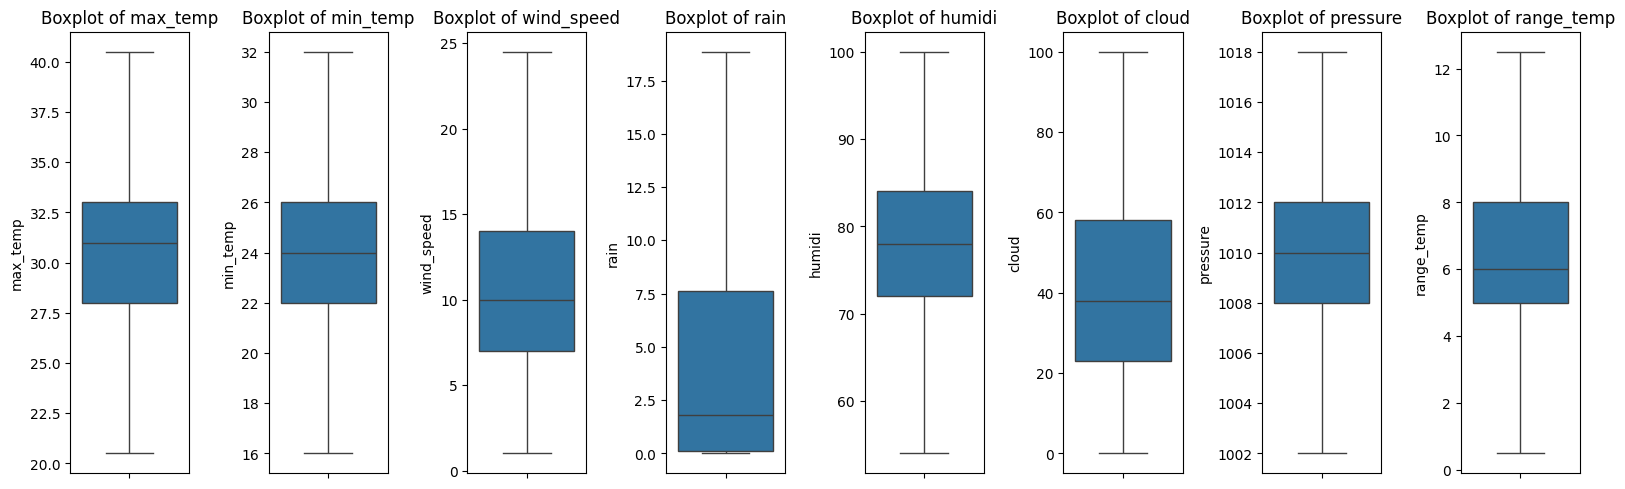

In [47]:
#box plot after
boxplots(df_clean.drop(columns=['region', 'day', 'month', 'year','is_rainy_season','is_dry_season','avg_rain_region','avg_rain_province','rain_1d_ago','rain_3d_avg','rain_7d_sum', 'rain_intensity','temp_humidity','cloud_humid','rain_trend_3d','wind_angle','wind_x','wind_y','cloud_temp_range','rain_2d_ago','Latitude','Longitude'], axis=1))

#**df_clean Overview**

In [48]:
#first 5 row of df_clean
display(df_clean.head())
print(df_clean.shape)

,province,max_temp,min_temp,wind_speed,wind_direct,rain,humidi,cloud,pressure,range_temp,...,wind_y,avg_rain_province,avg_rain_region,temp_humidity,cloud_humid,cloud_temp_range,rain_2d_ago,Latitude,Longitude,region
0,Bac Lieu,27.0,22,17.0,NNE,6.9,90,71,1010,5.0,...,0.000000,3.455858,4.768658,450,6390,355,0.0,9.329834,105.509946,Dong Bang Song Cuu Long
1,Bac Lieu,28.0,22,15.0,ENE,0.5,85,61,1010,6.0,...,0.000000,3.455858,4.768658,510,5185,366,0.0,9.329834,105.509946,Dong Bang Song Cuu Long
2,Bac Lieu,23.0,21,9.0,ESE,16.7,91,77,1011,2.0,...,0.000000,3.455858,4.768658,182,7007,154,6.9,9.329834,105.509946,Dong Bang Song Cuu Long
3,Bac Lieu,27.0,21,9.0,E,2.2,86,32,1011,6.0,...,9.000000,3.455858,4.768658,516,2752,192,0.5,9.329834,105.509946,Dong Bang Song Cuu Long
4,Bac Lieu,29.0,22,10.0,SE,0.0,81,25,1010,7.0,...,7.071068,3.455858,4.768658,567,2025,175,16.7,9.329834,105.509946,Dong Bang Song Cuu Long


(177411, 33)


In [49]:
#Download cleaned data
def downloadDf():
  from google.colab import files
  df_clean.to_csv('Cleaned_weather_data.csv', index=False)
  files.download('Cleaned_weather_data.csv')
  print('Download Successfully')

#downloadFf()

#**Identify factors that affect rainfall**

##OLS

In [50]:
# Get numeric columns only (excluding rain) 
numeric_cols = df_clean.select_dtypes(include='number').drop(columns=['rain']).columns

ols_metric = {}
for i in numeric_cols:
    ols_metric[i] = ols_metrics(df_clean, i, 'rain')

# Format results
ols_result = pd.DataFrame(ols_metric).T
ols_result.columns = ['adj_r_squared', 'f_statistic', 'Prob_F']

# Sort by performance
ols_result.sort_values(by='adj_r_squared', ascending=False)


,adj_r_squared,f_statistic,Prob_F
rain_1d_ago,0.236681,55010.308031,0.000000e+00
rain_trend_3d,0.224059,51229.438565,0.000000e+00
humidi,0.222942,50900.908833,0.000000e+00
cloud_humid,0.160872,34012.813343,0.000000e+00
is_rainy_season,0.136369,28014.349142,0.000000e+00
is_dry_season,0.136369,28014.349142,0.000000e+00
cloud,0.124416,25210.143548,0.000000e+00
rain_2d_ago,0.121790,24604.086384,0.000000e+00
pressure,0.088851,17301.211767,0.000000e+00
range_temp,0.080340,15499.254473,0.000000e+00


##Anova (one-way)

In [51]:
anova_metric = {}
for i in df_clean[['province', 'region', 'wind_direct']].columns:
  if i != 'rain':
    anova_metric[i] = anova_metrics(df_clean,'rain',i)

anova_result = pd.DataFrame(anova_metric).T
anova_result.columns = ['eta_squared', 'F_value', 'Prob_F']

anova_result.sort_values(by=['eta_squared'], ascending=False)

,eta_squared,F_value,Prob_F
wind_direct,0.071488,910.535415,0.0
province,0.041732,203.273848,0.0
region,0.018125,654.961711,0.0


In [52]:
ols_result = ols_result.rename(columns={
    'adj_r_squared': 'effect_size',
    'f_statistic': 'F_value',
    'Prob_F': 'Prob_F'
})
ols_result['feature_type'] = 'continuous'

anova_result = anova_result.rename(columns={
    'eta_squared': 'effect_size'
})
anova_result['feature_type'] = 'categorical'

# Combine both
combined_result = pd.concat([ols_result, anova_result])
combined_result = combined_result.reset_index().rename(columns={'index': 'feature'})

# Sort by effect size
combined_result_sorted = combined_result.sort_values(by='effect_size', ascending=False)

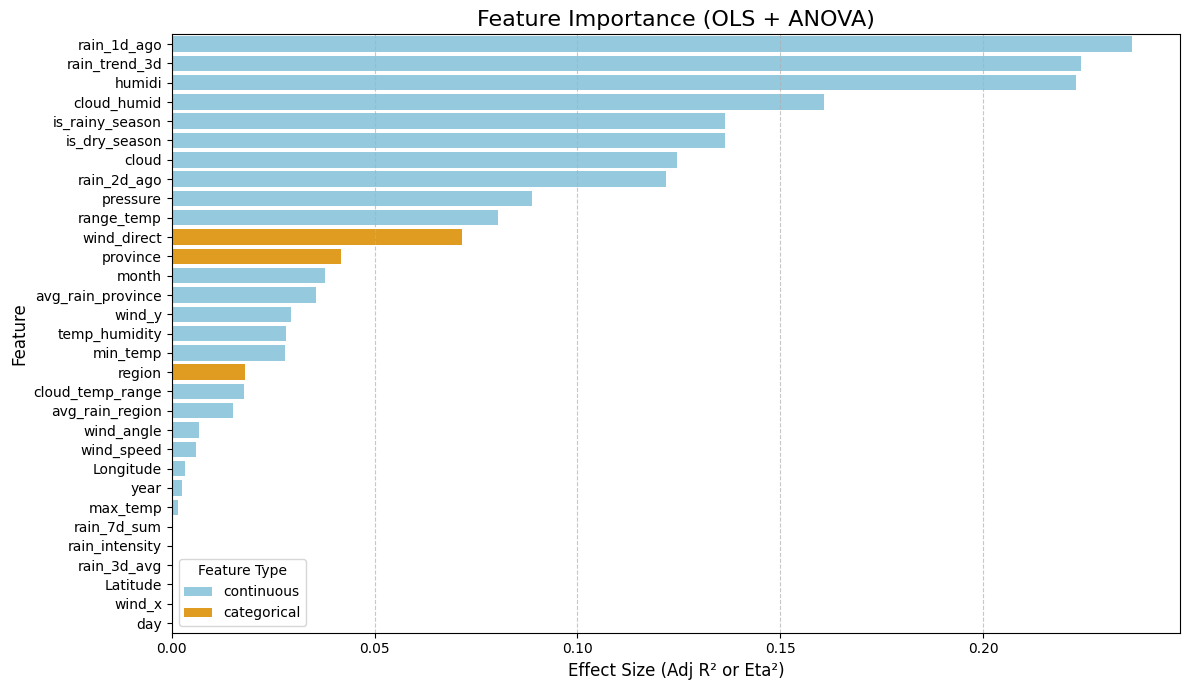

In [53]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=combined_result_sorted,
    x='effect_size',
    y='feature',
    hue='feature_type',
    dodge=False,
    palette={'continuous': 'skyblue', 'categorical': 'orange'}
)

plt.title('Feature Importance (OLS + ANOVA)', fontsize=16)
plt.xlabel('Effect Size (Adj R² or Eta²)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Feature Type')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [54]:
print(df_clean)

        province  max_temp  min_temp  wind_speed wind_direct  rain  humidi  \
0       Bac Lieu      27.0        22        17.0         NNE   6.9      90   
1       Bac Lieu      28.0        22        15.0         ENE   0.5      85   
2       Bac Lieu      23.0        21         9.0         ESE  16.7      91   
3       Bac Lieu      27.0        21         9.0           E   2.2      86   
4       Bac Lieu      29.0        22        10.0          SE   0.0      81   
...          ...       ...       ...         ...         ...   ...     ...   
177406   Yen Bai      32.0        23         6.0         ESE   7.3      79   
177407   Yen Bai      34.0        25         6.0         SSE   0.3      71   
177408   Yen Bai      36.0        27         6.0          SW   0.0      64   
177409   Yen Bai      37.0        28         7.0           S   0.0      66   
177410   Yen Bai      37.0        28         8.0         SSE   0.0      65   

        cloud  pressure  range_temp  ...        wind_y  avg_rai

In [ ]:
    "rain_1d_ago", "rain_trend_3d", "humidi", "cloud_humid",
    "is_rainy_season", "is_dry_season", "cloud", "rain_2d_ago",
    "pressure", "range_temp" "wind_direct", "province", "month",
    "avg_rain_province", "wind_y", "temp_humidity"

In [ ]:
features = [
    'humidi', 'cloud', 'pressure', 'cloud_humid',
    'is_rainy_season', 'is_dry_season',
    'max_temp', 'min_temp','range_temp',
    'rain_1d_ago', 'rain_2d_ago','rain_trend_3d','rain_intensity',         
    'wind_x', 'wind_y', 'Longitude', 'Latitude'                       
]

In [55]:
# Lưu toàn bộ dataframe đã xử lý ra file CSV
df_clean.to_csv("final_weather_processed.csv", index=False)

print(" File 'weather_processed.csv' đã được lưu!")


 File 'weather_processed.csv' đã được lưu!


In [65]:
model_df = pd.read_csv('final_weather_processed.csv')
features = [
    'humidi', 'cloud', 'pressure', 'cloud_humid','temp_humidity',
    'is_rainy_season', 'is_dry_season',
    'max_temp', 'min_temp','range_temp',
    'rain_1d_ago', 'rain_2d_ago','rain_trend_3d','rain_intensity','wind_angle',     
    'wind_x', 'wind_y', 'Longitude', 'Latitude'                       
]
X =model_df[features]
y =model_df['rain']

# --- Chia dữ liệu ---
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# --- Log-transform target ---
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# --- Hàm đánh giá mô hình ---
def evaluate_model(name, model, X_train, y_train_log, X_val, y_val):
    start_train = time.time()
    model.fit(X_train, y_train_log)
    train_time = time.time() - start_train

    start_infer = time.time()
    y_pred_log = model.predict(X_val)
    infer_time = (time.time() - start_infer) / len(X_val)

    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    return {
        'Model': name,
        'RMSE': round(rmse, 3),
        'R² Score (%)': round(r2 * 100, 2),
        'Train Time (s)': round(train_time, 2),
        'Inference Time (ms/sample)': round(infer_time * 1000, 4)
    }

# ================================
# 🔶 1. Random Forest
# ================================
param_dist_rf = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
search_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist_rf,
    n_iter=20, cv=3, verbose=1, random_state=42,
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
search_rf.fit(X_train, y_train_log)
best_rf = search_rf.best_estimator_

# ================================
# 🔶 2. KNN
# ================================
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1: Manhattan, 2: Euclidean
}
search_knn = RandomizedSearchCV(
    KNeighborsRegressor(),
    param_distributions=param_dist_knn,
    n_iter=10, cv=3, verbose=1, random_state=42,
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
search_knn.fit(X_train, y_train_log)
best_knn = search_knn.best_estimator_

# ================================
# 🔶 3. XGBoost
# ================================
param_dist_xgb = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [3, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}
search_xgb = RandomizedSearchCV(
    XGBRegressor(random_state=42, tree_method='hist', n_jobs=-1),
    param_distributions=param_dist_xgb,
    n_iter=30, cv=3, verbose=1, random_state=42,
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
search_xgb.fit(X_train, y_train_log)
best_xgb = search_xgb.best_estimator_

# ================================
# 🔶 Đánh giá tất cả mô hình
# ================================
results = []
results.append(evaluate_model("Random Forest", best_rf, X_train, y_train_log, X_val, y_val))
results.append(evaluate_model("KNN", best_knn, X_train, y_train_log, X_val, y_val))
results.append(evaluate_model("XGBoost", best_xgb, X_train, y_train_log, X_val, y_val))

# --- In kết quả ---
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='RMSE'))

# --- In tham số tốt nhất nếu cần ---
print("\nBest Params:")
print("Random Forest:", search_rf.best_params_)
print("KNN:", search_knn.best_params_)
print("XGBoost:", search_xgb.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [57]:
# df_results = pd.DataFrame(results)
# df_sorted = df_results.sort_values(by='RMSE')

# # ✅ In ra với định dạng rõ ràng
# for idx, row in df_sorted.iterrows():
#     print(f"{row['Model']:<12} | RMSE: {row['RMSE']:.3f} | R²: {row['R² Score (%)']:.2f} %")

# # --- In tham số tốt nhất nếu cần ---
# print("\nBest Params:")
# print("Random Forest:", search_rf.best_params_)
# print("KNN:", search_knn.best_params_)
# print("XGBoost:", search_xgb.best_params_)

In [58]:
# n_samples = 20
# np.random.seed(42)
# indices = np.random.choice(len(y_val), size=n_samples, replace=False)

# # --- Giá trị thực tế ---
# y_real_sample = y_val.iloc[indices].values
# x = np.arange(n_samples)

# # ==================================
# # 🔹 1. Biểu đồ cho Random Forest
# # ==================================
# y_pred_rf_log = best_rf.predict(X_val.iloc[indices])
# y_pred_rf = np.expm1(y_pred_rf_log)

# plt.figure(figsize=(12, 6))
# plt.bar(x - 0.2, y_real_sample, width=0.4, label='Thực tế', color='skyblue')
# plt.bar(x + 0.2, y_pred_rf, width=0.4, label='RF Dự đoán', color='orange')
# plt.xlabel('Mẫu')
# plt.ylabel('Lượng mưa (mm)')
# plt.title('So sánh lượng mưa thực tế và dự đoán (Validation) - Random Forest')
# plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

# # ==================================
# # 🔹 2. Biểu đồ cho KNN
# # ==================================
# y_pred_knn_log = best_knn.predict(X_val.iloc[indices])
# y_pred_knn = np.expm1(y_pred_knn_log)

# plt.figure(figsize=(12, 6))
# plt.bar(x - 0.2, y_real_sample, width=0.4, label='Thực tế', color='skyblue')
# plt.bar(x + 0.2, y_pred_knn, width=0.4, label='KNN Dự đoán', color='green')
# plt.xlabel('Mẫu')
# plt.ylabel('Lượng mưa (mm)')
# plt.title('So sánh lượng mưa thực tế và dự đoán (Validation) - KNN')
# plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

# # ==================================
# # 🔹 3. Biểu đồ cho XGBoost
# # ==================================
# dval_sample = xgb.DMatrix(X_val.iloc[indices].values)
# y_pred_xgb_log = xgb_model.predict(dval_sample)
# y_pred_xgb = np.expm1(y_pred_xgb_log)

# plt.figure(figsize=(12, 6))
# plt.bar(x - 0.2, y_real_sample, width=0.4, label='Thực tế', color='skyblue')
# plt.bar(x + 0.2, y_pred_xgb, width=0.4, label='XGBoost Dự đoán', color='purple')
# plt.xlabel('Mẫu')
# plt.ylabel('Lượng mưa (mm)')
# plt.title('So sánh lượng mưa thực tế và dự đoán (Validation) - XGBoost')
# plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


In [59]:
# importances = best_model.feature_importances_

# # Tạo DataFrame để sắp xếp
# feature_names = features  # danh sách feature bạn dùng khi train
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': importances
# }).sort_values(by='Importance', ascending=False)

# # Vẽ biểu đồ
# plt.figure(figsize=(10, 6))
# sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
# plt.title('Feature Importances - Random Forest')
# plt.xlabel('Mức độ quan trọng')
# plt.ylabel('Đặc trưng')
# plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


In [60]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from xgboost import XGBRegressor

# =========================
# 1. Đọc dữ liệu & chuẩn bị
# =========================
model_XGB = pd.read_csv('final_weather_processed.csv')

features = [
    'humidi', 'cloud', 'pressure', 'cloud_humid',
    'is_rainy_season', 'is_dry_season',
    'max_temp', 'min_temp','range_temp','wind_angle',
    'rain_1d_ago', 'rain_2d_ago','rain_trend_3d','rain_intensity',
    'wind_x', 'wind_y', 'Longitude', 'Latitude'
]

X = model_XGB[features]
y = model_XGB['rain']

# =========================
# 2. Chia train / val / test (60/20/20)
# =========================
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Log-transform target
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# =========================
# 3. Huấn luyện mô hình XGBoost với eval_set
# =========================
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.1,
    reg_lambda=1.5,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    n_jobs=-1,
    eval_metric='rmse'  y
)


xgb_model.fit(
    X_train, y_train_log,
    eval_set=[(X_train, y_train_log), (X_val, y_val_log)],
    verbose=False
)
train_time = time.time() - start_train

# =========================
# 4. Vẽ biểu đồ loss
# =========================
results = xgb_model.evals_result_
epochs = len(results['validation_0']['rmse'])
x_axis = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE (log-transformed)')
plt.title('Biểu đồ Loss (RMSE) theo từng vòng Boosting - XGBoost')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# =========================
# 5. Đánh giá mô hình
# =========================
start_infer = time.time()
y_val_pred_log = xgb_model.predict(X_val)
infer_time = (time.time() - start_infer) / len(X_val)

y_val_pred = np.expm1(y_val_pred_log)

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

# Accuracy phân loại (mưa hay không mưa, ngưỡng 1mm)
y_val_true_class = (y_val >= 1).astype(int)
y_val_pred_class = (y_val_pred >= 1).astype(int)
accuracy = accuracy_score(y_val_true_class, y_val_pred_class)

# =========================
# 6. In kết quả
# =========================
print("✅ Kết quả mô hình XGBoost:")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2 * 100:.2f}%")
print(f"Accuracy (mưa/không mưa): {accuracy * 100:.2f}%")
print(f"Train time: {train_time:.2f} s")
print(f"Inference time: {infer_time * 1000:.4f} ms/sample")


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1320687399.py, line 50)

In [ ]:
# percent_error = np.abs(y_real_sample - y_pred_sample) / (y_real_sample + 1e-5) * 100
# percent_accuracy = 100 - percent_error

# # --- In ra bảng phần trăm dự đoán ---
# result_df = pd.DataFrame({
#     'Actual (mm)': y_real_sample,
#     'Predicted (mm)': y_pred_sample,
#     'Accuracy (%)': np.round(percent_accuracy, 2)
# })

# print("\n Prediction Accuracy per Sample:")
# print(result_df.to_string(index=False))

In [ ]:
# from sklearn.metrics import classification_report

# # --- Convert to binary labels: rain or no rain ---
# threshold = 0.1  # or adjust as needed
# y_true_class = (y_val > threshold).astype(int)
# y_pred_class = (y_pred > threshold).astype(int)

# # --- Classification report ---
# report = classification_report(y_true_class, y_pred_class, target_names=['No Rain', 'Rain'])
# print("Classification Metrics (Rain vs No Rain):\n")
# print(report)


In [ ]:
# y_pred = np.expm1(y_pred_log)  # Khôi phục giá trị thật

# # Tính RMSE và R²
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# r2 = r2_score(y_val, y_pred)

# print(f"📊RMSE: {rmse:.3f} mm")
# print(f"📈R² Score: {r2 * 100:.2f} %")

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.metrics import accuracy_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# # Dữ liệu mẫu (thay bằng dữ liệu thật nếu có)
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=5000, n_features=20, n_classes=2,
#                            weights=[0.7, 0.3], random_state=42)

# # --- Chia dữ liệu 60/20/20
# X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# # --- Các mô hình và tham số
# param_grids = {
#     'KNN': {
#         'n_neighbors': [3, 5, 7, 9]
#     },
#     'Random Forest': {
#         'n_estimators': [100, 200],
#         'max_depth': [5, 10, None]
#     },
#     'XGBoost': {
#         'n_estimators': [100, 200],
#         'max_depth': [3, 5, 7],
#         'learning_rate': [0.05, 0.1, 0.2]
#     }
# }

# models = {
#     'KNN': KNeighborsClassifier(),
#     'Random Forest': RandomForestClassifier(random_state=42),
#     'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# }

# # --- Huấn luyện & đánh giá
# for name, model in models.items():
#     print(f"\n🔍 Tuning {name}...")
#     search = RandomizedSearchCV(model, param_grids[name], n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
#     search.fit(X_train, y_train)
    
#     best_model = search.best_estimator_
#     val_acc = accuracy_score(y_val, best_model.predict(X_val))
#     test_acc = accuracy_score(y_test, best_model.predict(X_test))
    
#     print(f"✅ Best params: {search.best_params_}")
#     print(f"📊 Validation Accuracy: {val_acc * 100:.2f}%")
#     print(f"🧪 Test Accuracy: {test_acc * 100:.2f}%")



🔍 Tuning KNN...


c:\Users\HNS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✅ Best params: {'n_neighbors': 9}
📊 Validation Accuracy: 84.80%
🧪 Test Accuracy: 84.00%

🔍 Tuning Random Forest...
✅ Best params: {'n_estimators': 200, 'max_depth': None}
📊 Validation Accuracy: 91.80%
🧪 Test Accuracy: 91.00%

🔍 Tuning XGBoost...


c:\Users\HNS\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\HNS\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:50:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best params: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05}
📊 Validation Accuracy: 92.50%
🧪 Test Accuracy: 90.30%


In [ ]:
# xgb_model = search.best_estimator_
# import joblib
# import os
# os.makedirs('models', exist_ok=True)  # Create folder if it doesn't exist


In [ ]:
# joblib.dump(xgb_model, 'models/xgb_model.pkl')  # Save it


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=20, n_informative=10, 
                           n_redundant=5, n_classes=2, weights=[0.7, 0.3], random_state=42)

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Khởi tạo mô hình
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Huấn luyện và in Accuracy
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ {name} Accuracy: {acc * 100:.2f}%")

✅ KNN Accuracy: 93.40%
✅ Random Forest Accuracy: 92.50%
✅ XGBoost Accuracy: 94.90%


c:\Users\HNS\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:47:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# mae = mean_absolute_error(y_val, y_pred)

# print(" Model Evaluation on Validation Set:")
# print(f"   RMSE: {round(rmse, 3)}")
# print(f"   MAE: {round(mae, 3)}")
# print(f"   R² Score: {round(r2 * 100, 2)} %")

In [ ]:
# joblib.dump(best_model, 'models/humidity_model.pkl')
# print(" Model saved to: models/humidity_model.pkl")